_Udacity Data Science Project: Submitted by Ms.Chingmuankim Naulak, Assistant Professor_

<h1 style="font-weight: normal;"> <b> Section 1:</b> Business Understanding </h1>

<h4 style="font-weight: normal;"> <b> Objective: </b> To uncover insights and patterns about Developers' Job and Salary Satisfaction from survey data using <a href="https://survey.stackoverflow.co/">2025 Stack Overflow Survey Data</a> and Machine learning algorithm. The main goal for performing this analysis is to help companies make better decisions about their compensation offer to attract competent employees. Below are the questions we need to answer by performing an experiment.</h4> 

<h4 style="font-weight: normal;">Q.1 What are the most important features of a dataset, how do they drive developers salaries?<br> 
Q.2 What unusual/creative insights can we uncover from the survey data?<br>
Q.3 How accurate is a Machine Learning model at predicting salaries from this information?<br>
Q.4 What happens in a what-if scenario-if we create a hypothetical developer profile, what salary would the model predict?

<h4 style="font-weight: normal;">To answer the above questions, we first need to consider the following key features: <br>

    - coding_experiences, location, education and number_of_experiences etc that influences salary 
    - correlations in salary growth 
    - unusual or creative insights from the survey data 
    - reliability of predictive analytics in salary forecasting 
    - simulating outcomes for different candidate profiles 

We will perform an experiment following the CRISP-DM process to analyze the data </h4>

<b>Step 1:</b> Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score, classification_report
RANDOM_STATE = 42
sns.set_theme(style="whitegrid")

<h1 style="font-weight: normal;"> <b> Section 2:</b> Data Understanding</h1> 

<b>Step 2:</b> Importing the dataset

In [2]:
from pathlib import Path
import re

CSV_IN  = Path("survey_results_public.csv")     # raw CSV file

In [3]:
pd.read_csv("survey_results_public.csv")

C:\Users\mwank\AppData\Local\Temp\ipykernel_6332\1696411179.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("survey_results_public.csv")


,ResponseId,MainBranch,Age,EdLevel,Employment,EmploymentAddl,WorkExp,LearnCodeChoose,LearnCode,LearnCodeAI,...,AIAgentOrchestration,AIAgentOrchWrite,AIAgentObserveSecure,AIAgentObsWrite,AIAgentExternal,AIAgentExtWrite,AIHuman,AIOpen,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,25-34 years old,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Employed,"Caring for dependents (children, elderly, etc.)",8.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,Vertex AI,NaN,NaN,NaN,ChatGPT,NaN,When I don’t trust AI’s answers,"Troubleshooting, profiling, debugging",61256.0,10.0
1,2,I am a developer by profession,25-34 years old,"Associate degree (A.A., A.S., etc.)",Employed,NaN,2.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,NaN,NaN,When I don’t trust AI’s answers;When I want to...,All skills. AI is a flop.,104413.0,9.0
2,3,I am a developer by profession,35-44 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Independent contractor, freelancer, or self-em...",None of the above,10.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,ChatGPT;Claude Code;GitHub Copilot;Google Gemini,NaN,When I don’t trust AI’s answers;When I want to...,"Understand how things actually work, problem s...",53061.0,8.0
3,4,I am a developer by profession,35-44 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed,None of the above,4.0,"Yes, I am not new to coding but am learning ne...","Other online resources (e.g. standard search, ...","Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,ChatGPT;Claude Code,NaN,When I don’t trust AI’s answers;When I want to...,NaN,36197.0,6.0
4,5,I am a developer by profession,35-44 years old,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...","Caring for dependents (children, elderly, etc.)",21.0,"No, I am not new to coding and did not learn n...",NaN,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,NaN,NaN,When I don’t trust AI’s answers,"critical thinking, the skill to define the tas...",60000.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49123,49119,I am a developer by profession,25-34 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed,NaN,9.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools req...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
49124,49120,I am a developer by profession,35-44 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed,"Caring for dependents (children, elderly, etc.)",13.0,"No, I am not new to coding and did not learn n...",NaN,"Yes, I learned how to use AI-enabled tools req...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49125,49121,I am a developer by profession,25-34 years old,"Secondary school (e.g. American high school, G...",Employed,NaN,2.0,"Yes, I am not new to coding but am learning ne...","Other online resources (e.g. standard search, ...","No, I didn't spend time learning in the past year",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49126,49122,I am a developer by profession,25-34 years old,"Associate degree (A.A., A.S., etc.)",Employed,None of the above;Engaged in paid work (20-29 ...,10.0,"No, I am not new to coding and did not learn n...",NaN,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0


Data before cleaning has 49128 rows × 170 columns

<h1 style="font-weight: normal;"> <b> Section 3:</b> Data Preparation </h1> 

<b>Step 3:</b> Cleaning the raw data

In [4]:
CSV_OUT = CSV_IN.with_name(CSV_IN.stem + "__clean.csv")  # saving the clean CSV file 
ENCODINGS_TO_TRY = ["utf-8-sig", "utf-8", "latin-1"]   # read a text file

def repair_csv_quotes(in_path: Path, out_path: Path, encoding_candidates=ENCODINGS_TO_TRY):
    """
    Repairs common CSV issues:
    - CRLF/CR mixing → normalize to '\n'
    - Embedded newlines inside quoted fields → stitch lines until quotes are balanced
    - NUL bytes removed
    Returns the encoding used.
    """
    enc_used = None
    for enc in encoding_candidates:
        try:
            raw = in_path.read_text(encoding=enc, errors="strict")
            enc_used = enc
            break
        except Exception:
            continue
    if enc_used is None:
        # last resort: read ignoring errors
        enc_used = encoding_candidates[-1]
        raw = in_path.read_text(encoding=enc_used, errors="ignore")

    # Normalize newlines & strip NULs
    raw = raw.replace("\r\n", "\n").replace("\r", "\n").replace("\x00", "")

    # Stitch lines until we have an even number of double quotes
    out_lines = []
    buf = []
    quote_count = 0
    for line in raw.split("\n"):
        buf.append(line)
        quote_count += line.count('"')
        if quote_count % 2 == 0:
            # balanced → flush buffer as one line
            out_lines.append("\n".join(buf))
            buf = []
            quote_count = 0
    # If file ends with an unbalanced buffer, flush anyway
    if buf:
        out_lines.append("\n".join(buf))

    # Optional: collapse accidental internal newlines that got stitched
    # Replace internal newlines inside a row with literal spaces (safer for parsing)
    out_text = "\n".join(l.replace("\n", " ") for l in out_lines)

    out_path.write_text(out_text, encoding="utf-8")
    return enc_used

def try_read_csv(path: Path):
    # Try fast path
    try:
        return pd.read_csv(path, low_memory=False)
    except Exception:
        # Try python engine & skip irreparable rows
        return pd.read_csv(
            path,
            engine="python",
            on_bad_lines="skip",
            dtype=str,            # keep as strings first
            quotechar='"',
            escapechar="\\",
        )

#REPAIRING ERRORS IN ORIGINAL DATA
used = repair_csv_quotes(CSV_IN, CSV_OUT)
print(f"Cleaned CSV written to: {CSV_OUT} (source encoding: {used})")

Cleaned CSV written to: survey_results_public__clean.csv (source encoding: utf-8-sig)


Loading the cleaned data

In [5]:
df = try_read_csv(CSV_OUT)
print("Loaded shape:", df.shape)
print("First columns:", list(df.columns)[:12])
df.head(3)

Loaded shape: (49128, 170)
First columns: ['ResponseId', 'MainBranch', 'Age', 'EdLevel', 'Employment', 'EmploymentAddl', 'WorkExp', 'LearnCodeChoose', 'LearnCode', 'LearnCodeAI', 'AILearnHow', 'YearsCode']


,ResponseId,MainBranch,Age,EdLevel,Employment,EmploymentAddl,WorkExp,LearnCodeChoose,LearnCode,LearnCodeAI,...,AIAgentOrchestration,AIAgentOrchWrite,AIAgentObserveSecure,AIAgentObsWrite,AIAgentExternal,AIAgentExtWrite,AIHuman,AIOpen,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,25-34 years old,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Employed,"Caring for dependents (children, elderly, etc.)",8.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,Vertex AI,NaN,NaN,NaN,ChatGPT,NaN,When I don’t trust AI’s answers,"Troubleshooting, profiling, debugging",61256.0,10.0
1,2,I am a developer by profession,25-34 years old,"Associate degree (A.A., A.S., etc.)",Employed,NaN,2.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,NaN,NaN,When I don’t trust AI’s answers;When I want to...,All skills. AI is a flop.,104413.0,9.0
2,3,I am a developer by profession,35-44 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Independent contractor, freelancer, or self-em...",None of the above,10.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,ChatGPT;Claude Code;GitHub Copilot;Google Gemini,NaN,When I don’t trust AI’s answers;When I want to...,"Understand how things actually work, problem s...",53061.0,8.0


<b>Step 4:</b> Plotting a histogram

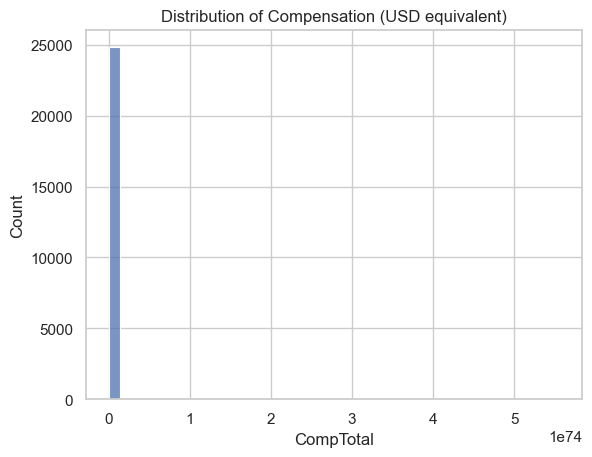

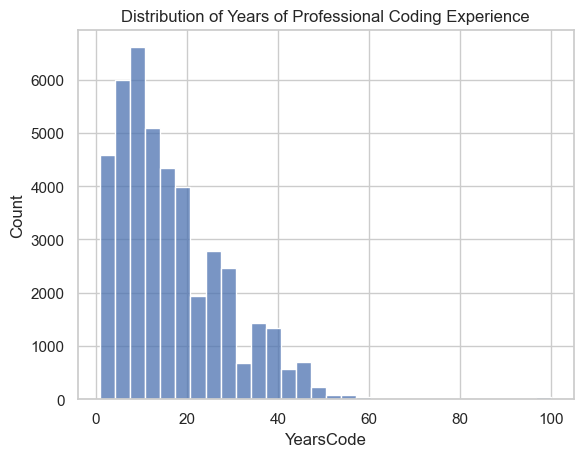

In [6]:
# Compensation distribution
sns.histplot(df["CompTotal"], bins=40)
plt.title("Distribution of Compensation (USD equivalent)")
plt.show()

# Years coding distribution
sns.histplot(df["YearsCode"], bins=30)
plt.title("Distribution of Years of Professional Coding Experience")
plt.show()

The histogram shows that it is right skewed suggesting that most developers have  approximately 20 years of experience in coding i.e more number of developers have 5–20 years of coding experience. The peak (mode) appears around 10 years. After 20 years, the counts decline steadily, with relatively few developers reporting more than 40 years of coding experience. This suggests the developer population is concentrated in the early to mid-career range, with far fewer very senior professionals.

<b>Hiring implication:</b> The majority of potential hires will likely have less than 20 years of experience. Managers should be prepared to see resumes clustering in that range.

<h1 style="font-weight: normal;"> <b> Section 4:</b> Data Modeling </h1> 

<b>Step 5:</b> Foundation for building machine learning model

In this step, we will perform three operations:<br>
i) <b>Cleaning:</b> Removes any rows where the annual salary is missing <br>
ii) <b>Selection:</b> Selecting meaningful features that are expected to influence the salary<br>
iii) <b>Declaring dependent variables:</b> Defining the prediction target

In [7]:
# Considering these input features(independent variables) that influence salaries
df_model = df.dropna(subset=["ConvertedCompYearly"]).copy()
features = ["Country", "YearsCode", "LearnCodeChoose", "AILearnHow"]  #features to be extracted
# Output Variable(annual salary) we want to predict(dependent)
target = "ConvertedCompYearly"

Here, we select Years of Coding as key feature that influence salary. In order to perform further computation, we first need to convert into numeric values.

In [8]:
# Convert YearsCodePro to numeric
df_model["YearsCode"] = pd.to_numeric(df_model["YearsCode"], errors="coerce")
df_model = df_model.dropna(subset=["YearsCode"])

X = df_model[features]  #Extracts the input features (independent variables) from the cleaned DataFrame
y = np.log1p(df_model[target].astype(float)) #transforming the target using logarithmic scale

<b>Step 6:</b> Building a Data Preprocessing Pipeline

In [9]:
numeric_features = ["YearsCode"]  #this is the numeric columnn
categorical_features = ["Country", "LearnCodeChoose", "AILearnHow"] # These are the categorical columns that needs encoding

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")), #Fills missing values with the most common category
    ("scaler", StandardScaler())
])

#Converts categorical columns into binary columns (one-hot encoding), and safely ignores unseen categories during prediction.
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

After encoding we will start preprocessing the data

In [10]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

<b>Step 7:</b> Fitting and Validation of the Model

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=RANDOM_STATE)

rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE))
])

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("R2:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))


R2: 0.2521097875811422
RMSE: 1.343618103425782


<h1 style="font-weight: normal;"> <b> Section 5:</b> Evaluation </h1> 

 <h3> Q.1 What are the most important features of a dataset, how do they drive developers salaries ? </h3>

<b>Step 8:</b> Feature Importance Visualization

In this step, we will see only top 15 features that drive the developers salary

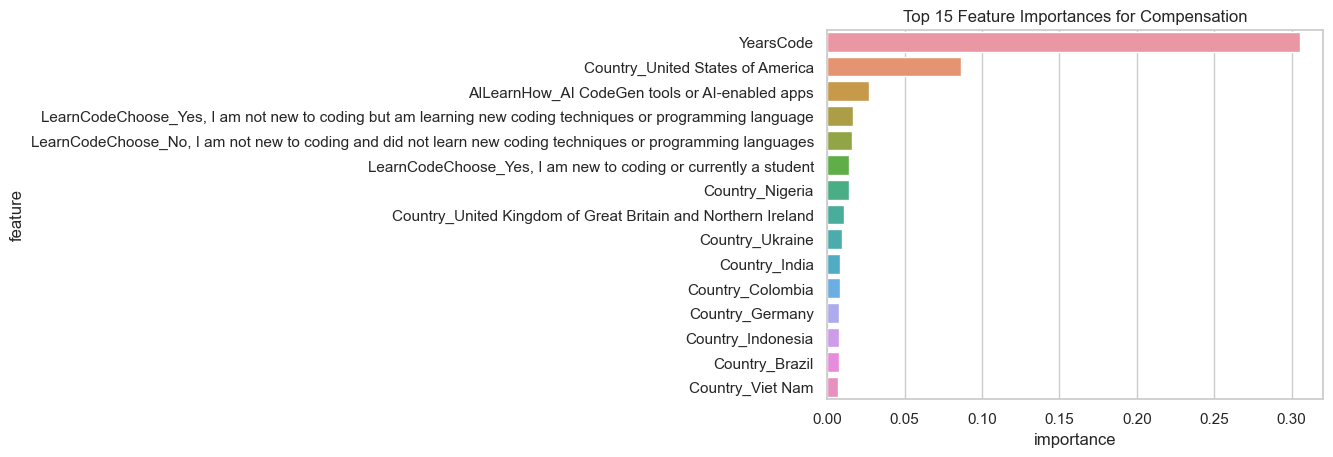

In [12]:
ohe = rf.named_steps["preprocess"].named_transformers_["cat"].named_steps["encoder"]
cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_names)

importances = rf.named_steps["model"].feature_importances_
imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
imp_df = imp_df.sort_values("importance", ascending=False).head(15)

sns.barplot(x="importance", y="feature", data=imp_df)
plt.title("Top 15 Feature Importances for Compensation")
plt.show()


Earlier, we have extracted some features that are expected to drive the developers salary which are: <b>Coding experience, Country, How they learn AI, Whether they choose to learn new coding</b>. As per the visualization result of the dataset, Coding experience scores the highest, followed by a country from the USA, How they learn AI, Whether these developers choose to learn new coding<br>
     a) Yes: not new but learing new programming <br>
     b) No : not new and not learn new programming <br>
     c) Yes: new and currently a student <br>
a Country from Nigeria, UK and Northern Ireland, India, Colombia, Germany, Indonesia, Brazil, VietNam

<h3> Q.2 What unusual/creative insights can we uncover from the survey data? </h3>

- check model's ability to capture meaningful patterns
- how satisfied are the developers with their job?

<h3> Checking Model's ability to capture </h3>

Compensation Model Performance
R2: 0.2521097875811422
RMSE: 1.343618103425782


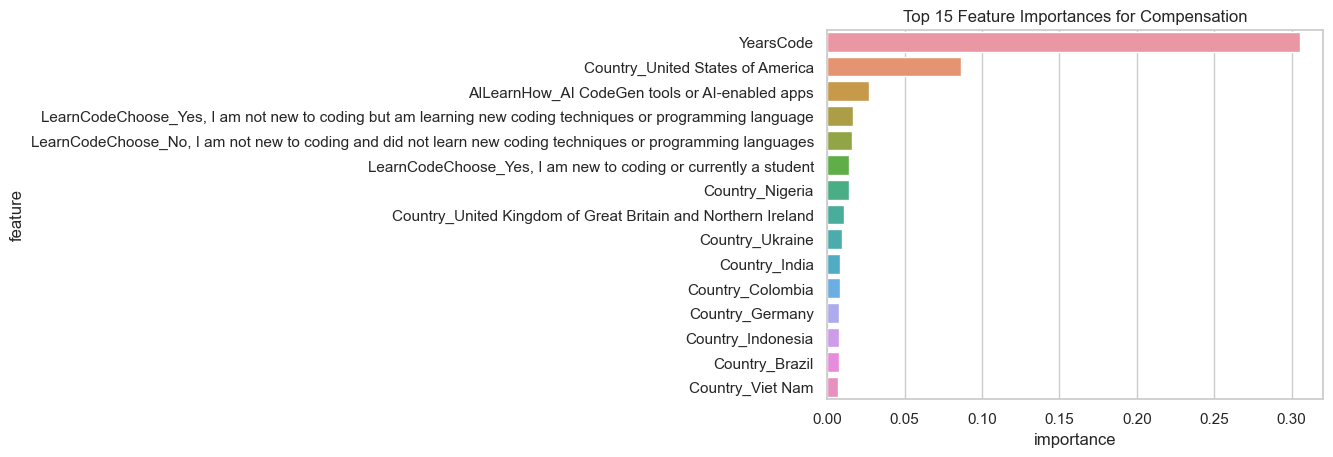

In [13]:
#Model: Random Forest Regressor

rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE))
])

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Compensation Model Performance")
print("R2:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

# Feature Importance
ohe = rf.named_steps["preprocess"].named_transformers_["cat"].named_steps["encoder"]
cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_names)

importances = rf.named_steps["model"].feature_importances_
imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
imp_df = imp_df.sort_values("importance", ascending=False).head(15)

sns.barplot(x="importance", y="feature", data=imp_df)
plt.title("Top 15 Feature Importances for Compensation")
plt.show()

About 25% of the variance are in developer salaries which is not so good, neither useless. The RMSE measures the average error in predictions. Result shows that model is capturing some meaningful patterns, but there’s room to improve. Performance can be boosted by:
- Adding more features (e.g., job role, education level, company type)
- Using feature engineering (e.g., grouping countries by income level)
- Trying more advanced models or tuning hyperparameters

<h3> Job Satisfaction Prediction </h3> 

In [14]:
# Keep subset with JobSat responses
df_class = df.dropna(subset=["JobSat"]).copy()

# Convert JobSat to binary target
# Example: "Very satisfied" / "Slightly satisfied" → 1, others → 0
#df_class["JobSatBinary"] = df_class["JobSat"].apply(
    #lambda x: 1 if "satisfied" in str(x).lower() else 0
#)
# Making a Binary Satisfaction Column
df_class['JobSatBinary'] = df_class['JobSat'].apply(
    lambda x: 1 if pd.notnull(x) and x >= 7 else 0
)

# Check distribution
print(df_class['JobSatBinary'].value_counts())
print(df_class['JobSatBinary'].value_counts(normalize=True) * 100)

# Features: Similar to regression, but can add WorkWeekHrs
features_class = ["Country", "YearsCode", "LearnCodeChoose", "AILearnHow", "WorkExp"]
target_class = "JobSatBinary"

# Preprocess features
df_class["YearsCode"] = pd.to_numeric(df_class["YearsCode"], errors="coerce")
df_class = df_class.dropna(subset=["YearsCode", "WorkExp"])

Xc = df_class[features_class]
yc = df_class[target_class]


1    19066
0     7577
Name: JobSatBinary, dtype: int64
1    71.56101
0    28.43899
Name: JobSatBinary, dtype: float64


In [15]:
# --- Preprocessing for classification ---
numeric_features_class = ["YearsCode", "WorkExp"]
categorical_features_class = ["Country", "LearnCodeChoose", "AILearnHow"]

numeric_transformer_class = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer_class = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_class = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_class, numeric_features_class),
        ("cat", categorical_transformer_class, categorical_features_class)
    ]
)

<h3> Q.3 How accurate is a Machine Learning model at predicting salaries from this information?</h3>

In [16]:
# --- Train/Test Split ---
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    Xc, yc, test_size=0.2, random_state=RANDOM_STATE, stratify=yc
)

clf = Pipeline(steps=[
    ("preprocess", preprocess_class),
    ("model", RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE))
])

clf.fit(Xc_train, yc_train)
yc_pred = clf.predict(Xc_test)

print("Job Satisfaction Model Performance")
print("Accuracy:", accuracy_score(yc_test, yc_pred))
print("F1:", f1_score(yc_test, yc_pred))
print("\nClassification Report:\n", classification_report(yc_test, yc_pred))


Job Satisfaction Model Performance
Accuracy: 0.6863768115942029
F1: 0.8041510800048268

Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.15      0.21      1459
           1       0.73      0.90      0.80      3716

    accuracy                           0.69      5175
   macro avg       0.55      0.52      0.51      5175
weighted avg       0.63      0.69      0.64      5175



Earlier, the accuracy shows the model is predicting everything correctly but F1 shows that the model is not predicting the positive class at all. The reason was due to <b>Class Imbalance Problem</b> , where almost all the data is in the negative class, due to which the model always predicts “negative” and have achieved near-perfect accuracy, but its F1 score (for the positive class) was 0 because it never catches positives.

After correcting the binary satisfaction column by making rating ≥ 7 to be satisfied and < 0 be not satisfied, we achieved a fair result showing an Accuracy of ~69% which means the model correctly predicts job satisfaction for about 69% of the test cases and F10 of ~80%. This is quite strong. It means the model has a good balance of precision and recall for the positive class (those marked as “satisfied”).The F1 score being higher than accuracy suggests the model is good at finding the positives.

In [17]:
print("Class distribution:\n", yc.value_counts())

# If yc is a numpy array
unique, counts = np.unique(yc, return_counts=True)
print(dict(zip(unique, counts)))

# Percentages
print("Class percentages:\n", yc.value_counts(normalize=True) * 100)

Class distribution:
 1    18580
0     7294
Name: JobSatBinary, dtype: int64
{0: 7294, 1: 18580}
Class percentages:
 1    71.809539
0    28.190461
Name: JobSatBinary, dtype: float64


- Class distribution: Only class 0 exists (25,874 rows).
- Class percentages: 100% of the data is labeled as 0.
- There are no positive samples (1) in the target variable JobSatBinary.

Lets see if there is any changes in our result by making changes in the data

In [18]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(yc_test, yc_pred))

[[ 220 1239]
 [ 384 3332]]


TN (True Negatives) = 220
The model correctly predicted 220 people as not satisfied.

FP (False Positives) = 1239
The model predicted satisfied when they were actually not satisfied.
→ These are “overly optimistic” predictions.

FN (False Negatives) = 384
The model predicted not satisfied when they were actually satisfied.
→ These are missed opportunities (could matter if retention is the goal).

TP (True Positives) = 3332
The model correctly predicted 3332 people as satisfied.

Model leans toward predicting “satisfied”, Much higher TP (3332) than TN (220). But also a lot of FP (1239), meaning it overestimates satisfaction.

Recall for Satisfied Employees is high: TP / (TP + FN) = 3332 / (3332 + 384) ≈ 0.90
So the model is very good at finding satisfied employees.

Precision for Satisfied Employees is lower:TP / (TP + FP) = 3332 / (3332 + 1239) ≈ 0.73
About 27% of the time when the model predicts “satisfied,” it’s wrong.

Unsatisfied class suffers TN is very low (220) compared to FP (1239).

The model struggles to correctly identify dissatisfied employees.


<b>Since one of our business goal is to find satisfied employees, the model is doing quiet well (high recall)</b>

<h3> Feature Importance for Classification </h3>

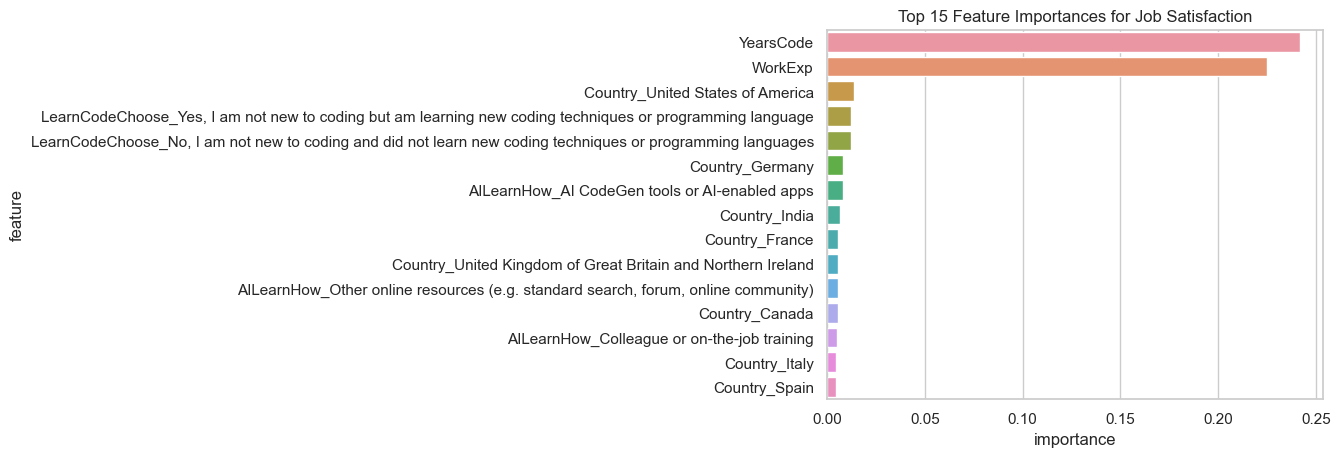

In [19]:
# Feature importances
ohe_class = clf.named_steps["preprocess"].named_transformers_["cat"].named_steps["encoder"]
cat_names_class = ohe_class.get_feature_names_out(categorical_features_class)
feature_names_class = numeric_features_class + list(cat_names_class)

importances_class = clf.named_steps["model"].feature_importances_
imp_class_df = pd.DataFrame({"feature": feature_names_class, "importance": importances_class})
imp_class_df = imp_class_df.sort_values("importance", ascending=False).head(15)

sns.barplot(x="importance", y="feature", data=imp_class_df)
plt.title("Top 15 Feature Importances for Job Satisfaction")
plt.show()

<h3>Creative Scenario (Classification)</h3>

In [29]:
# Creative Scenario for Job Satisfaction
new_dev_class = pd.DataFrame({
    "Country": ["India"],
    "YearsCode": [5],
    "LearnCodeChoose": ["Python;TypeScript"],
    "AILearnHow": ["AI coding assistant"],
    "WorkExp": [40]
})

satisfaction_pred = clf.predict(new_dev_class)[0]
print("Predicted Job Satisfaction:", "Satisfied" if satisfaction_pred == 1 else "Not satisfied")

Predicted Job Satisfaction: Satisfied


<h3> Q.4 What happens in a what-if scenario-if we create a hypothetical developer profile, what salary would the model predict? </h3>

We will try to predict the salary of developers from two different locations to see its impact

In [21]:
#Creating developer's profile
new_dev = pd.DataFrame({
    "Country": ["India"],
    "YearsCode": [5],
    "LearnCodeChoose": ["Python;TypeScript"],
    "AILearnHow": ["AI coding assistant"]
})

#predicting their salary
predicted_salary = np.expm1(rf.predict(new_dev))[0]
print(f"Predicted annual compensation: ${predicted_salary:,.0f} USD equivalent")

Predicted annual compensation: $9,604 USD equivalent


The result shows quite a low wage for a person living in India with an experience of 5 years

In [22]:
#Creating developer's profile
new_dev = pd.DataFrame({
    "Country": ["USA"],
    "YearsCode": [5],
    "LearnCodeChoose": ["Python;TypeScript"],
    "AILearnHow": ["AI coding assistant"]
})

#predicting their salary
predicted_salary = np.expm1(rf.predict(new_dev))[0]
print(f"Predicted annual compensation: ${predicted_salary:,.0f} USD equivalent")

Predicted annual compensation: $26,585 USD equivalent


The result shows much higher wage for a person living in the US with an experience of 5 years 